In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")
df_products_prior = pd.read_csv("order_products__prior.csv")
df_products_train = pd.read_csv("order_products__train.csv")

In [4]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
df_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
df_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
len(df_products_prior)

32434489

In [9]:
len(df_products_train)

1384617

In [10]:
total_products = df_products_prior.append(df_products_train)
len(total_products)

/var/folders/cy/fmqnchh16r708wgv26794x5m0000gn/T/ipykernel_1291/3599825547.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_products = df_products_prior.append(df_products_train)


33819106

In [11]:
total_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
#merge the dataframes (products prior and train with products)
product_counts = total_products.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[:250].reset_index(drop = True)
product_counts = product_counts.merge(df_products, on = 'product_id', how = 'left')
product_counts.head(10)

,product_id,frequency,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4
5,47766,184224,Organic Avocado,24,4
6,47626,160792,Large Lemon,24,4
7,16797,149445,Strawberries,24,4
8,26209,146660,Limes,24,4
9,27845,142813,Organic Whole Milk,84,16


In [13]:
freq_products = list(product_counts.product_id)
freq_products[1:10]

[13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209, 27845]

In [14]:
len(freq_products)

250

In [15]:
order_products = total_products[total_products.product_id.isin(freq_products)]
order_products.shape

(11263044, 4)

In [16]:
order_products = order_products.merge(df_products, on = 'product_id', how='left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,17794,6,1,Carrots,83,4
3,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16
4,3,24838,2,1,Unsweetened Almondmilk,91,16


In [24]:
#encoding 
#do not re-run plz it takes like 15 minutes
basket = order_products.groupby(['order_id', 'product_name'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat Milk,2% Reduced Fat Organic Milk,Air Chilled Organic Boneless Skinless Chicken Breasts,Apple Honeycrisp Organic,Asparagus,Asparation/Broccolini/Baby Broccoli,Baby Spinach,Bag of Organic Bananas,Banana,Bartlett Pears,Blackberries,Blueberries,Boneless Skinless Chicken Breast,Boneless Skinless Chicken Breasts,Broccoli Crown,Brussels Sprouts,Bunched Cilantro,Cantaloupe,Carrots,Cherubs Heavenly Salad Tomatoes,Chicken & Maple Breakfast Sausage,Clementines,"Clementines, Bag",Creamy Almond Butter,Creamy Peanut Butter,Cucumber Kirby,Electrolyte Enhanced Water,European Cucumber,Extra Virgin Olive Oil,Ezekiel 4:9 Bread Organic Sprouted Whole Grain,Fat Free Milk,Feta Cheese Crumbles,Fresh Cauliflower,Fresh Ginger Root,...,Sparkling Lemon Water,Sparkling Mineral Water,Sparkling Natural Mineral Water,Sparkling Water Berry,Sparkling Water Grapefruit,Spinach,Spring Water,Strawberries,Sustainably Soft Bath Tissue,Sweet Onion,Total 0% Greek Yogurt,Total 0% Nonfat Greek Yogurt,Total 2% All Natural Greek Strained Yogurt with Honey,Total 2% All Natural Plain Greek Yogurt,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total Greek Strained Yogurt,Trilogy Kombucha Drink,Uncured Genoa Salami,Uncured Hickory Smoked Sunday Bacon,Unsalted Butter,Unsalted Pure Irish Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Unsweetened Vanilla Almond Milk,Vanilla Almond Breeze Almond Milk,Vanilla Skyr Nonfat Yogurt,Watermelon Chunks,Whipped Cream Cheese,White Corn,White Onion,Whole Milk,Yellow Bell Pepper,Yellow Onions,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry"
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
basket.size

679927250

In [19]:
basket.shape

(2719709, 250)

In [20]:
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [21]:
frequent_items.head()

,support,itemsets
0,0.014439,(100% Raw Coconut Water)
1,0.010680,(100% Recycled Paper Towels)
2,0.023206,(100% Whole Wheat Bread)
3,0.014204,(2% Reduced Fat Milk)
4,0.032089,(Apple Honeycrisp Organic)


In [22]:
frequent_items.shape

(160, 2)

In [21]:
df_dept_clusters = pd.read_csv("clusters.csv")

In [22]:
df_dept_clusters.head()

,Unnamed: 0,user_id,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day_x,days_since_prior_order_x,cluster,order_id,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order_y
0,0,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3,2539329,prior,1,2,8,NaN
1,1,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3,2398795,prior,2,3,7,15.0
2,2,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3,473747,prior,3,3,12,21.0
3,3,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3,2254736,prior,4,4,7,29.0
4,4,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3,431534,prior,5,4,15,28.0


In [23]:
order_products_dept = order_products.merge(df_dept_clusters, on = 'order_id', how='left')
order_products_dept.head()

,order_id,product_id,add_to_cart_order,reordered_x,product_name,aisle_id,department_id,Unnamed: 0,user_id,0,1,2,3,4,5,6,7,8,9,reordered_y,order_hour_of_day_x,days_since_prior_order_x,cluster,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order_y
0,2,33120,1,1,Organic Egg Whites,86,16,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
2,2,17794,6,1,Carrots,83,4,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
3,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,3417191,205970,0.082286,-0.031116,-0.021239,-0.034774,0.069774,0.045614,-0.022272,0.037316,0.003348,0.021922,0.735285,0.164954,-0.780770,2,prior,16,5,17,12.0
4,3,24838,2,1,Unsweetened Almondmilk,91,16,3417191,205970,0.082286,-0.031116,-0.021239,-0.034774,0.069774,0.045614,-0.022272,0.037316,0.003348,0.021922,0.735285,0.164954,-0.780770,2,prior,16,5,17,12.0


In [38]:
cluster_1 = order_products_dept[order_products_dept['cluster'] == 1]
cluster_1

,order_id,product_id,add_to_cart_order,reordered_x,product_name,aisle_id,department_id,Unnamed: 0,user_id,0,1,2,3,4,5,6,7,8,9,reordered_y,order_hour_of_day_x,days_since_prior_order_x,cluster,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order_y
0,2,33120,1,1,Organic Egg Whites,86,16,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
2,2,17794,6,1,Carrots,83,4,3355525,202279,-0.001448,-0.119004,-0.019774,0.039013,-0.011740,0.044896,-0.005182,-0.003973,-0.014843,0.023084,0.214612,-0.185950,0.982516,1,prior,3,5,9,8.0
40,18,8021,1,0,100% Recycled Paper Towels,54,17,1979365,118860,0.089206,-0.030445,0.020220,-0.021119,0.027984,0.010342,0.020222,0.039026,-0.002417,0.001292,1.593005,1.568569,-0.890975,1,prior,3,4,20,6.0
41,18,34969,2,1,Red Vine Tomato,83,4,1979365,118860,0.089206,-0.030445,0.020220,-0.021119,0.027984,0.010342,0.020222,0.039026,-0.002417,0.001292,1.593005,1.568569,-0.890975,1,prior,3,4,20,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11263013,3420909,25146,6,1,Original Orange Juice,31,7,145833,8765,0.012236,-0.037976,0.070067,-0.010067,-0.013264,-0.009964,0.003838,-0.034849,-0.014823,0.027487,1.002521,0.866762,-0.229743,1,train,31,0,19,13.0
11263014,3420909,21938,7,1,Green Bell Pepper,83,4,145833,8765,0.012236,-0.037976,0.070067,-0.010067,-0.013264,-0.009964,0.003838,-0.034849,-0.014823,0.027487,1.002521,0.866762,-0.229743,1,train,31,0,19,13.0
11263015,3420909,24184,8,1,Red Peppers,83,4,145833,8765,0.012236,-0.037976,0.070067,-0.010067,-0.013264,-0.009964,0.003838,-0.034849,-0.014823,0.027487,1.002521,0.866762,-0.229743,1,train,31,0,19,13.0
11263016,3420909,21137,9,1,Organic Strawberries,24,4,145833,8765,0.012236,-0.037976,0.070067,-0.010067,-0.013264,-0.009964,0.003838,-0.034849,-0.014823,0.027487,1.002521,0.866762,-0.229743,1,train,31,0,19,13.0


In [39]:
basket = cluster_1.groupby(['order_id', 'product_name'])['reordered_x'].count().unstack().reset_index().fillna(0).set_index('order_id')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat Milk,2% Reduced Fat Organic Milk,Air Chilled Organic Boneless Skinless Chicken Breasts,Apple Honeycrisp Organic,Asparagus,Asparation/Broccolini/Baby Broccoli,Baby Spinach,Bag of Organic Bananas,Banana,Bartlett Pears,Blackberries,Blueberries,Boneless Skinless Chicken Breast,Boneless Skinless Chicken Breasts,Broccoli Crown,Brussels Sprouts,Bunched Cilantro,Cantaloupe,Carrots,Cherubs Heavenly Salad Tomatoes,Chicken & Maple Breakfast Sausage,Clementines,"Clementines, Bag",Creamy Almond Butter,Creamy Peanut Butter,Cucumber Kirby,Electrolyte Enhanced Water,European Cucumber,Extra Virgin Olive Oil,Ezekiel 4:9 Bread Organic Sprouted Whole Grain,Fat Free Milk,Feta Cheese Crumbles,Fresh Cauliflower,Fresh Ginger Root,...,Sparkling Lemon Water,Sparkling Mineral Water,Sparkling Natural Mineral Water,Sparkling Water Berry,Sparkling Water Grapefruit,Spinach,Spring Water,Strawberries,Sustainably Soft Bath Tissue,Sweet Onion,Total 0% Greek Yogurt,Total 0% Nonfat Greek Yogurt,Total 2% All Natural Greek Strained Yogurt with Honey,Total 2% All Natural Plain Greek Yogurt,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total Greek Strained Yogurt,Trilogy Kombucha Drink,Uncured Genoa Salami,Uncured Hickory Smoked Sunday Bacon,Unsalted Butter,Unsalted Pure Irish Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Unsweetened Vanilla Almond Milk,Vanilla Almond Breeze Almond Milk,Vanilla Skyr Nonfat Yogurt,Watermelon Chunks,Whipped Cream Cheese,White Corn,White Onion,Whole Milk,Yellow Bell Pepper,Yellow Onions,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry"
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
basket.size

109788750

In [41]:
basket.shape

(439155, 250)

In [42]:
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [43]:
frequent_items.head()

,support,itemsets
0,0.013036,(100% Raw Coconut Water)
1,0.011292,(100% Recycled Paper Towels)
2,0.023386,(100% Whole Wheat Bread)
3,0.015095,(2% Reduced Fat Milk)
4,0.026173,(Apple Honeycrisp Organic)


In [44]:
frequent_items.shape

(149, 2)

In [59]:
#Association Rules for Cluster 1
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)[:20]
rules.to_csv("Rules_Segmentation_.csv", index = False)

In [60]:
#Association Rules for Cluster 2
cluster_2 = order_products_dept[order_products_dept['cluster'] == 2]
basket = cluster_2.groupby(['order_id', 'product_name'])['reordered_x'].count().unstack().reset_index().fillna(0).set_index('order_id')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)[:20]
rules.to_csv("Rules_Segmentation_2.csv", index = False)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [62]:
cluster_0 = order_products_dept[order_products_dept['cluster'] == 0]
basket = cluster_0.groupby(['order_id', 'product_name'])['reordered_x'].count().unstack().reset_index().fillna(0).set_index('order_id')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)[:20]
rules.to_csv("Rules_Segmentation_0.csv", index = False)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [61]:
#Association Rules for Cluster 3
cluster_3 = order_products_dept[order_products_dept['cluster'] == 3]
basket = cluster_3.groupby(['order_id', 'product_name'])['reordered_x'].count().unstack().reset_index().fillna(0).set_index('order_id')
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)[:20]
rules.to_csv("Rules_Segmentation_3.csv", index = False)

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


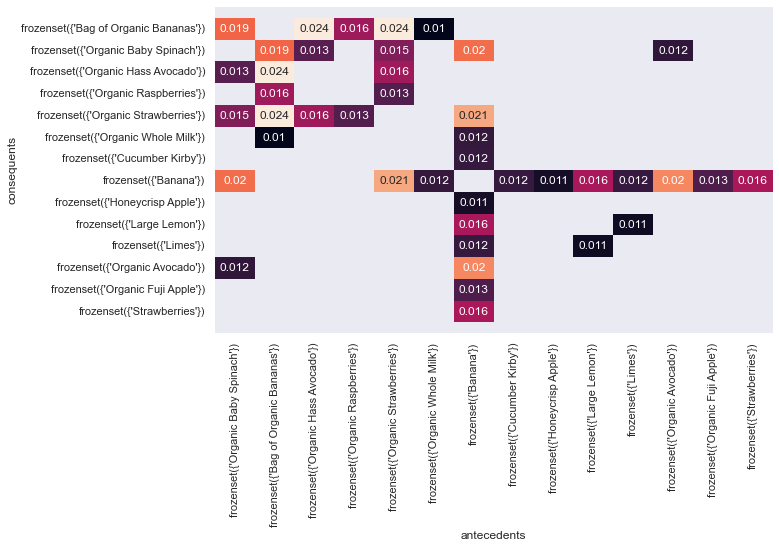

In [24]:
#Heatmap with Support

# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show()

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


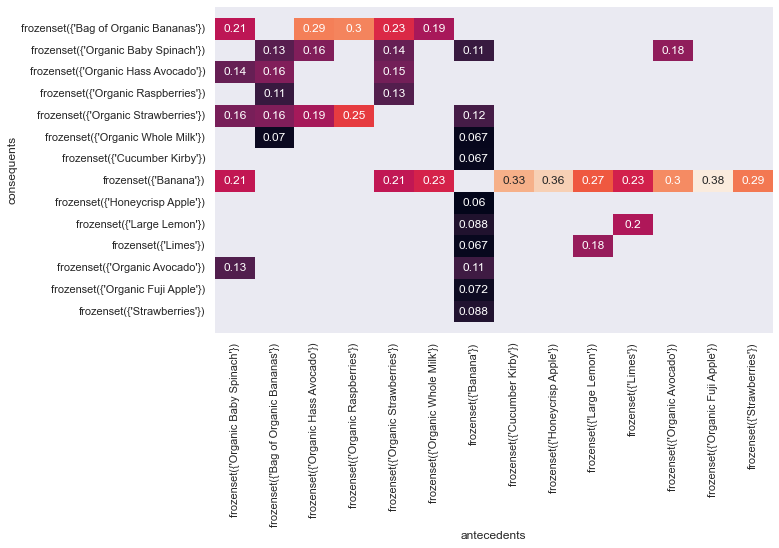

In [25]:
#Heatmap with Confidence

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules.pivot(index = 'consequents', 
                    columns = 'antecedents', values= 'confidence')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

/Users/nicolepham-nguyen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


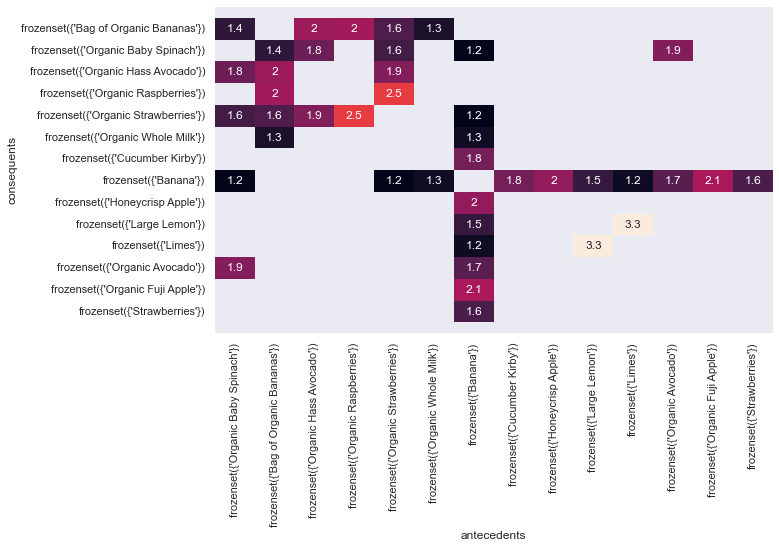

In [26]:
#Heatmap with Lift

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules.pivot(index = 'consequents', 
                    columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

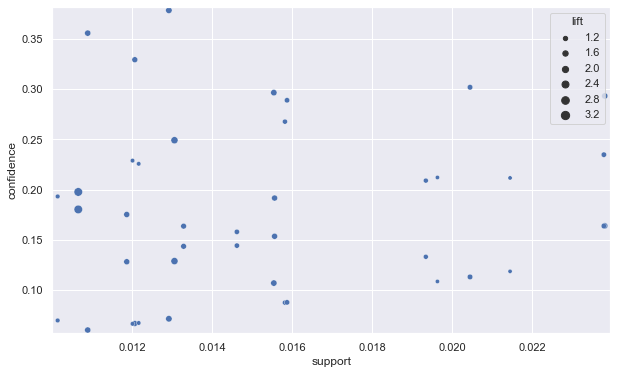

In [27]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()

#Not really getting anything from the scatterplot

In [19]:
df = pd.read_csv("dept_clusers.csv")
df

,user_id,cluster
0,1,0
1,2,0
2,3,2
3,4,0
4,5,3
...,...,...
206204,206205,2
206205,206206,0
206206,206207,2
206207,206208,2


In [20]:
product_counts = total_products.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[:250].reset_index(drop = True)
product_counts = product_counts.merge(df_products, on = 'product_id', how = 'left')
product_counts.head(10)

,product_id,frequency,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4
5,47766,184224,Organic Avocado,24,4
6,47626,160792,Large Lemon,24,4
7,16797,149445,Strawberries,24,4
8,26209,146660,Limes,24,4
9,27845,142813,Organic Whole Milk,84,16


In [22]:
df_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [ ]:
total_counts = product_counts.merge(df, on = 'product_id', how = 'left')